# Arquitetura do Modelo 5

## Etapa 1 - Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'3.4.3'

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

TensorFlow 2.x selected.


'2.0.0'

## Etapa 2 - Conectando com o Drive e acessando os arquivos

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/Material.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
base_imgs = 'Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall("./")
zip_object.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Etapa 3 - Acessando a base com fotos de expressões faciais



In [ ]:
data = pd.read_csv('fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


Text(0.5, 1.0, 'Imagens x emoções')

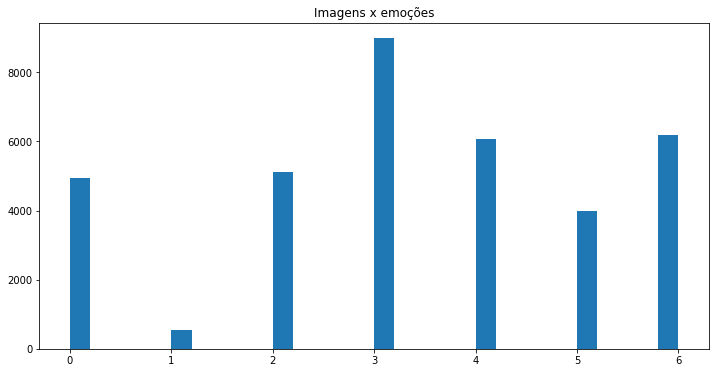

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins=30)
plt.title("Imagens x emoções")

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

## Etapa 4 - Pré-processamento

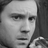

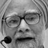

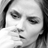

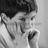

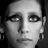

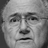

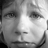

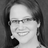

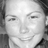

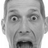

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [ ]:
pixels = data['pixels'].tolist()
largura, altura = 48, 48

faces = []
amostras = 0 
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura) 
  faces.append(face)
  
  if (amostras < 10):
    cv2_imshow(face)

  amostras = amostras + 1

faces = np.asarray(faces) 
faces = np.expand_dims(faces, -1)

def normalizar(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

faces = normalizar(faces)

emocoes = pd.get_dummies(data['emotion']).as_matrix() 

In [ ]:
print("Número total de imagens no dataset: "+str(len(faces)))

Número total de imagens no dataset: 35887


## Etapa 5 - Imports do Tensorflow/Keras

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

## Etapa 6 - Dividir em conjuntos para treinamento e validação

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(faces, emocoes, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=41)

print("Número de imagens no conjunto de treinamento:", len(x_train))
print("Número de imagens no conjunto de testes:", len(x_test))
print("Número de imagens no conjunto de validação:", len(y_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de testes: 3589
Número de imagens no conjunto de validação: 3230


In [ ]:
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

## Etapa 7 - Arquitetura do Modelo (CNN)

### Arquitetura do modelo

Implementação original: https://github.com/maelfabien/Multimodal-Emotion-Recognition/blob/master/03-Video/Notebooks/00-Fer2013.ipynb

In [ ]:
batch_size = 256
epochs = 100
width, height = 48, 48
num_labels = 7

model = Sequential() 

model.add(Conv2D(20, (3, 3), padding='same', activation='relu', input_shape=(width, height, 1)))
model.add(Conv2D(30, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(40, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(60, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(70, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(80, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(90, (3, 3), padding='same', activation='relu'))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 20)        200       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 30)        5430      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 30)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 30)        120       
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 40)        10840     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 50)        1

## Etapa 8 - Compilando o modelo 

In [ ]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
arquivo_modelo = "modelo_05_expressoes.h5" # arquivo do modelo
arquivo_modelo_json = "modelo_05_expressoes.json" # arquivo do json, para salvar a arquitetura
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True)

### Salvando a arquitetura do modelo em um arquivo JSON

In [ ]:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

## Etapa 9 - Treinando o modelo

In [ ]:
history = model.fit(np.array(x_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(x_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Train on 29068 samples, validate on 3230 samples
Epoch 1/100
28928/29068 [============================>.] - ETA: 0s - loss: 1.7742 - accuracy: 0.2813
Epoch 00001: val_loss improved from inf to 1.81928, saving model to modelo_05_expressoes.h5
29068/29068 [==============================] - 17s 580us/sample - loss: 1.7736 - accuracy: 0.2817 - val_loss: 1.8193 - val_accuracy: 0.2594
Epoch 2/100
28928/29068 [============================>.] - ETA: 0s - loss: 1.5011 - accuracy: 0.4177
Epoch 00002: val_loss did not improve from 1.81928
29068/29068 [==============================] - 11s 363us/sample - loss: 1.5012 - accuracy: 0.4175 - val_loss: 1.8247 - val_accuracy: 0.2601
Epoch 3/100
28928/29068 [============================>.] - ETA: 0s - loss: 1.3563 - accuracy: 0.4750
Epoch 00003: val_loss did not improve from 1.81928
29068/29068 [==============================] - 11s 363us/sample - loss: 1.3562 - accuracy: 0.4749 - val_loss: 1.8953 - val_accuracy: 0.3263
Epoch 4/100
28928/29068 [=========

## Gerando gráfico da melhora em cada etapa do treinamento

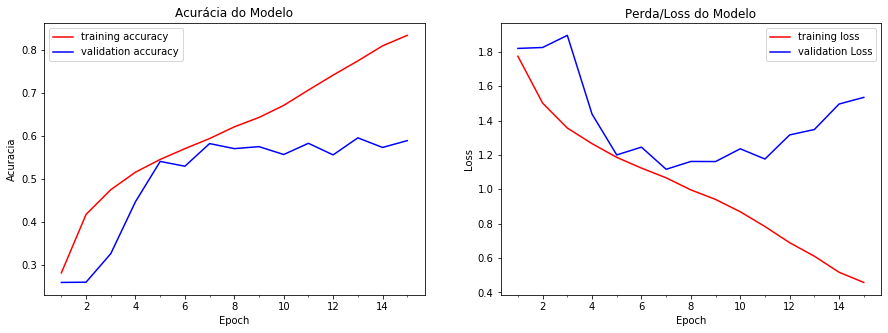

In [ ]:
def plota_historico_modelo(historico_modelo):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(historico_modelo.history['accuracy'])+1),
                historico_modelo.history['accuracy'],'r')
    axs[0].plot(range(1,len(historico_modelo.history['val_accuracy'])+1),
                historico_modelo.history['val_accuracy'],'b')
    axs[0].set_title('Acurácia do Modelo')
    axs[0].set_ylabel('Acuracia')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(historico_modelo.history['accuracy'])+1),
                      len(historico_modelo.history['accuracy'])/10)
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    axs[1].plot(range(1,len(historico_modelo.history['loss'])+1),
                historico_modelo.history['loss'],'r')
    axs[1].plot(range(1,len(historico_modelo.history['val_loss'])+1),
                historico_modelo.history['val_loss'],'b')
    axs[1].set_title('Perda/Loss do Modelo')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(historico_modelo.history['loss'])+1),
                      len(historico_modelo.history['loss'])/10)
    axs[1].legend(['training loss', 'validation Loss'], loc='best')
    fig.savefig('historico_modelo_mod01.png')
    plt.show()

plota_historico_modelo(history)

### Verificando a acurácia do modelo

In [ ]:
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Acurácia: " + str(scores[1]))
print("Perda/Loss: " + str(scores[0]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Carregaremos os dados para gerar a matriz de confusão

In [ ]:
true_y=[]
pred_y=[]
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')
json_file = open(arquivo_modelo_json, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(arquivo_modelo)
y_pred= loaded_model.predict(x)
yp = y_pred.tolist()
yt = y.tolist()
count = 0
for i in range(len(y)):
    yy = max(yp[i])
    yyt = max(yt[i])
    pred_y.append(yp[i].index(yy))
    true_y.append(yt[i].index(yyt))
    if(yp[i].index(yy)== yt[i].index(yyt)):
        count+=1
acc = (count/len(y))*100
np.save('truey__mod01', true_y)
np.save('predy__mod01', pred_y)
print("Acurácia no conjunto de testes: "+str(acc)+"%")

Acurácia no conjunto de testes: 56.70103092783505%


## Gerando a Matriz de Confusão

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = np.load('truey__mod01.npy')
y_pred = np.load('predy__mod01.npy')
cm = confusion_matrix(y_true, y_pred)
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
titulo='Matriz de Confusão'
print(cm)

[[234   9  36  49  82  15  73]
 [ 11  20   8   2   6   3   2]
 [ 63   5 130  58 141  55  93]
 [ 31   0  13 741  35  16  45]
 [ 55   2  50  62 289   5 125]
 [ 12   1  29  40  22 277  33]
 [ 53   1  24  65 121   3 344]]


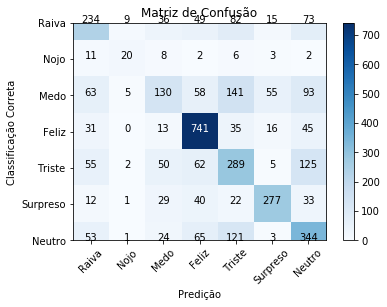

In [ ]:
import itertools
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(titulo)
plt.colorbar()
tick_marks = np.arange(len(expressoes))
plt.xticks(tick_marks, expressoes, rotation=45)
plt.yticks(tick_marks, expressoes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Classificação Correta')
plt.xlabel('Predição')
plt.savefig('matriz_confusao_mod01.png')
plt.show()

## Testando brevemente o modelo

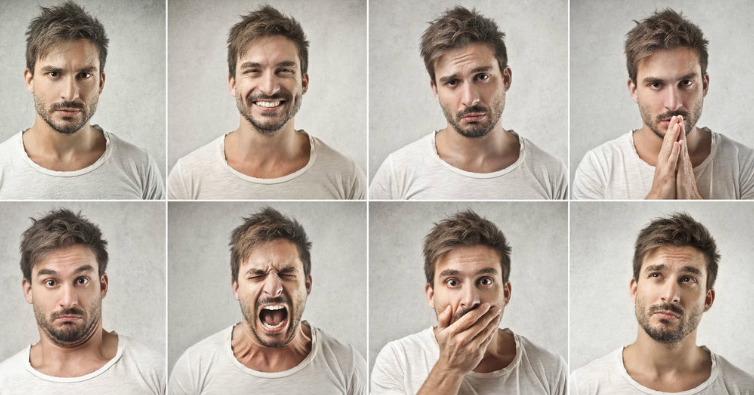

In [ ]:
imagem = cv2.imread("Material/testes/teste02.jpg")
cv2_imshow(imagem)

In [ ]:
model = load_model("modelo_05_expressoes.h5")
scores = model.evaluate(np.array(x_test), np.array(y_test), batch_size=batch_size)
print("Perda/Loss: " + str(scores[0]))
print("Acurácia: " + str(scores[1]))

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

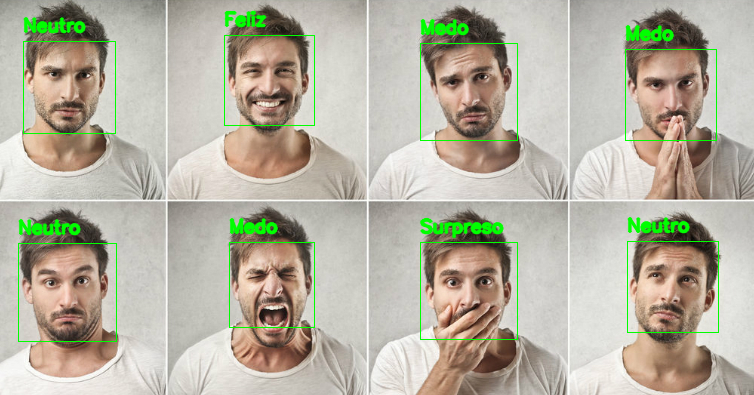

In [ ]:
expressoes = ["Raiva", "Nojo", "Medo", "Feliz", "Triste", "Surpreso", "Neutro"]
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)
for (x, y, w, h) in faces:
    cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
    roi_gray = gray[y:y + h, x:x + w]
    roi_gray = roi_gray.astype("float") / 255.0
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, 
                  norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)
    prediction = model.predict(cropped_img)[0]
    cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)
cv2_imshow(original)